<a href="https://colab.research.google.com/github/socome/NetVLAD-Example-on-Colab/blob/master/NetVLAD_manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[***출처: 심현주님의 블로그를 참고했습니다.***](https://medium.com/hyunjulie/%EC%BA%90%EA%B8%80%EA%B3%BC-%EA%B5%AC%EA%B8%80-colab-%EC%97%B0%EA%B2%B0%ED%95%B4%EC%A3%BC%EA%B8%B0-6a274f6de81d)


**1. 먼저 본인의 캐글 계정에서 API Token 을 다운받습니다.**

![업로드방법](https://cdn-images-1.medium.com/max/800/1*yvocb2Sbyf_ZbBxUcJM7rA.png)

**오른쪽 상단에서 My Account 에 들어갑니다**

![API받기](https://cdn-images-1.medium.com/max/800/1*JgVnYqQh6mEEoKCLayFz9g.png)

**Create New API Token 을 누르면 kaggle.json 파일이 다운로드 됩니다. 이 파일은 찾기 쉬운곳에 일단 옮겨두고,**

**아래의 셀을 실행합니다. 여기서 '파일선택'을 누르고 kaggle.json을 업로드합니다.**

In [0]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kjwdubu","key":"8102b3d8bbebf5a2e4413cf0246da13a"}'}

In [0]:
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d kjwdubu/netvlad-sejong-dataset
!unzip netvlad-sejong-dataset.zip
!tar -xvzf NetVLAD_dataset.tgz

 99% 1.49G/1.50G [00:19<00:00, 62.2MB/s]
100% 1.50G/1.50G [00:19<00:00, 82.7MB/s]
Archive:  netvlad-sejong-dataset.zip
  inflating: NetVLAD_dataset.tgz     
Sejong/
Sejong/test/
Sejong/train/
Sejong/test/AI/
Sejong/test/Clock tower/
Sejong/test/desktop.ini
Sejong/test/Front door Child/
Sejong/test/Front door Sejong/
Sejong/test/Museum/
Sejong/test/Stone statue/
Sejong/train/AI/
Sejong/train/Clock tower/
Sejong/train/desktop.ini
Sejong/train/Front door Child/
Sejong/train/Front door Sejong/
Sejong/train/Museum/
Sejong/train/Stone statue/
Sejong/test/AI/1245_1167_139.jpg
Sejong/test/AI/42523.png
Sejong/test/AI/desktop.ini
Sejong/test/AI/IMAGE0007.jpg
Sejong/test/AI/IMAGE0009.jpg
Sejong/test/AI/IMAGE0023.jpg
Sejong/test/AI/IMAGE0026.jpg
Sejong/test/AI/IMAGE0030.jpg
Sejong/test/AI/IMAGE0033.jpg
Sejong/test/AI/IMAGE0036.jpg
Sejong/test/AI/IMAGE0042.jpg
Sejong/test/AI/IMAGE0047.jpg
Sejong/test/AI/IMAGE0176.jpg
Sejong/test/AI/IMAGE0178.jpg
Sejong/test/AI/IMAGE0180.jpg
Sejong/test/AI/IMAGE0181


# **다음과 같이 정상적으로 설치 됐는지 확인합니다.**

![확인](https://user-images.githubusercontent.com/44772344/58857792-015ac400-86e1-11e9-9cd3-a4f772cfccfe.PNG)


**다음으로는 NetVLAD와 TripletNEt을 섞은 EmbedNet을 통해서 학습을 진행할 예정입니다.**

![모델](https://user-images.githubusercontent.com/44772344/58701146-24cdf800-83dd-11e9-924d-4e5e247bfec3.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tensorflow as tf

from torch.autograd import Variable
from torchvision.models import resnet18

from tensorflow import keras
from keras.preprocessing import image

import PIL
import torch
import torchvision

import matplotlib.pyplot as plt
from sklearn import svm, datasets, metrics

torch.manual_seed(777)

Using TensorFlow backend.


In [2]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab
tb = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://a4913122.ngrok.io


## **NetVLAD와 TripletLoss를 결합하는 코드는 다음 깃허브에서 참고했습니다.**

# [바로가기](https://github.com/lyakaap/NetVLAD-pytorch)


In [0]:
class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, num_clusters=6, dim=128, alpha=100.0,
                 normalize_input=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=True)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self._init_params()

    def _init_params(self):
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        self.conv.bias = nn.Parameter(
            - self.alpha * self.centroids.norm(dim=1)
        )

    def forward(self, x):
        N, C = x.shape[:2]

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(N, C, -1)
        
        # calculate residuals to each clusters
        residual = x_flatten.expand(self.num_clusters, -1, -1, -1).permute(1, 0, 2, 3) - \
            self.centroids.expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
        residual *= soft_assign.unsqueeze(2)
        vlad = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad

In [0]:
class EmbedNet(nn.Module):
    def __init__(self, base_model, net_vlad):
        super(EmbedNet, self).__init__()
        self.base_model = base_model
        self.net_vlad = net_vlad

    def forward(self, x):
        x = self.base_model(x)
        embedded_x = self.net_vlad(x)
        return embedded_x
      
class TripletNet(nn.Module):
    def __init__(self, embed_net):
        super(TripletNet, self).__init__()
        self.embed_net = embed_net

    def forward(self, a, p, n):
        embedded_a = self.embed_net(a)
        embedded_p = self.embed_net(p)
        embedded_n = self.embed_net(n)
        return embedded_a, embedded_p, embedded_n

    def feature_extract(self, x):
        return self.embed_net(x)

In [0]:
class HardTripletLoss(nn.Module):
    """Hard/Hardest Triplet Loss
    (pytorch implementation of https://omoindrot.github.io/triplet-loss)
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    """
    def __init__(self, margin=0.1, hardest=False, squared=False):
        """
        Args:
            margin: margin for triplet loss
            hardest: If true, loss is considered only hardest triplets.
            squared: If true, output is the pairwise squared euclidean distance matrix.
                If false, output is the pairwise euclidean distance matrix.
        """
        super(HardTripletLoss, self).__init__()
        self.margin = margin
        self.hardest = hardest
        self.squared = squared

    def forward(self, embeddings, labels):
        """
        Args:
            labels: labels of the batch, of size (batch_size,)
            embeddings: tensor of shape (batch_size, embed_dim)
        Returns:
            triplet_loss: scalar tensor containing the triplet loss
        """
        pairwise_dist = _pairwise_distance(embeddings, squared=self.squared)

        if self.hardest:
            # Get the hardest positive pairs
            mask_anchor_positive = _get_anchor_positive_triplet_mask(labels).float()
            valid_positive_dist = pairwise_dist * mask_anchor_positive
            hardest_positive_dist, _ = torch.max(valid_positive_dist, dim=1, keepdim=True)

            # Get the hardest negative pairs
            mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()
            max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
            anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (
                    1.0 - mask_anchor_negative)
            hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

            # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
            triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + 0.1)
            triplet_loss = torch.mean(triplet_loss)
        else:
            anc_pos_dist = pairwise_dist.unsqueeze(dim=2)
            anc_neg_dist = pairwise_dist.unsqueeze(dim=1)

            # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
            # triplet_loss[i, j, k] will contain the triplet loss of anc=i, pos=j, neg=k
            # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
            # and the 2nd (batch_size, 1, batch_size)
            loss = anc_pos_dist - anc_neg_dist + self.margin

            mask = _get_triplet_mask(labels).float()
            triplet_loss = loss * mask

            # Remove negative losses (i.e. the easy triplets)
            triplet_loss = F.relu(triplet_loss)

            # Count number of hard triplets (where triplet_loss > 0)
            hard_triplets = torch.gt(triplet_loss, 1e-16).float()
            num_hard_triplets = torch.sum(hard_triplets)

            triplet_loss = torch.sum(triplet_loss) / (num_hard_triplets + 1e-16)

        return triplet_loss


def _pairwise_distance(x, squared=False, eps=1e-16):
    # Compute the 2D matrix of distances between all the embeddings.

    cor_mat = torch.matmul(x, x.t())
    norm_mat = cor_mat.diag()
    distances = norm_mat.unsqueeze(1) - 2 * cor_mat + norm_mat.unsqueeze(0)
    distances = F.relu(distances)

    if not squared:
        mask = torch.eq(distances, 0.0).float()
        distances = distances + mask * eps
        distances = torch.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    # Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    indices_not_equal = torch.eye(labels.shape[0]).to(device).byte() ^ 1

    # Check if labels[i] == labels[j]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)

    mask = indices_not_equal * labels_equal

    return mask


def _get_anchor_negative_triplet_mask(labels):
    # Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    # Check if labels[i] != labels[k]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    mask = labels_equal ^ 1

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Check that i, j and k are distinct
    indices_not_same = torch.eye(labels.shape[0]).to(device).byte() ^ 1
    i_not_equal_j = torch.unsqueeze(indices_not_same, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_same, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_same, 0)
    distinct_indices = i_not_equal_j * i_not_equal_k * j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = torch.eq(torch.unsqueeze(labels, 0), torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)
    valid_labels = i_equal_j * (i_equal_k ^ 1)

    mask = distinct_indices * valid_labels   # Combine the two masks

    return mask

In [0]:
# Discard layers at the end of base network
encoder = resnet18(pretrained=True)
base_model = nn.Sequential(
    encoder.conv1,
    encoder.bn1,
    encoder.relu,
    encoder.maxpool,
    encoder.layer1,
    encoder.layer2,
    encoder.layer3,
    encoder.layer4,
)
dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)

# Define model for embedding
net_vlad = NetVLAD(num_clusters=6, dim=dim, alpha=1.0)
model = EmbedNet(base_model, net_vlad).cuda()

## 실제 학습을 진행하는 부분입니다. 
#### Epoch = ??/ batch = 8을 설정하겠습니다. 

In [0]:
# Define loss
criterion = HardTripletLoss(margin=0.1).cuda()
epochs = 50
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

 #### 'colab oserror errno 5 input/output error' 를 해결하기 위해 
 #### 모든 데이터를 로드해 캐시에 저장하고 이후에 학습을 진행하겠습니다. 

In [0]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128,128)),               
    torchvision.transforms.ToTensor()
    
])

bef_train_imagenet_data = torchvision.datasets.ImageFolder('./Sejong/train', transform=transforms)
bef_train_data_loader = torch.utils.data.DataLoader(bef_train_imagenet_data,
                                          batch_size=721,
                                          shuffle=False,
                                          num_workers=0)

In [0]:
for bef_train_image,bef_train_label in bef_train_data_loader :
  bef_train_image = bef_train_image
  bef_train_label = bef_train_label

In [0]:
train_imagenet_data = torchvision.datasets.ImageFolder('./Sejong/train', transform=transforms)
train_data_loader = torch.utils.data.DataLoader(train_imagenet_data,
                                          batch_size=8,
                                          shuffle=True,
                                          num_workers=0)
test_imagenet_data = torchvision.datasets.ImageFolder('./Sejong/test', transform=transforms)
test_data_loader = torch.utils.data.DataLoader(test_imagenet_data,
                                          shuffle=False,
                                          batch_size=126,
                                          num_workers=0)

In [12]:
globaliter = 0

for epoch in range(epochs):
  for batch_idx, (train_image,train_label) in enumerate(train_data_loader) :
    output_train = model(train_image.cuda())
    triplet_loss = criterion(output_train, train_label.cuda())
    optimizer.zero_grad()
    triplet_loss.backward(retain_graph=True)
    optimizer.step()
    # This is where I'm recording to Tensorboard
    tb.save_value('Train Loss', 'train_loss', globaliter, triplet_loss.item())
    print('epoch : {}, globaliter : {}, batch_idx  : {}, triplet_loss : {}'.format(epoch,globaliter,batch_idx,triplet_loss.item()))
    globaliter += 1
  model_save_name = 'model_{:02d}.pt'.format(epoch)
  path = F"./{model_save_name}" 
  torch.save(model.state_dict(), path)

epoch : 0, globaliter : 0, batch_idx  : 0, triplet_loss : 0.09322059154510498
epoch : 0, globaliter : 1, batch_idx  : 1, triplet_loss : 0.09958328306674957
epoch : 0, globaliter : 2, batch_idx  : 2, triplet_loss : 0.09534075856208801
epoch : 0, globaliter : 3, batch_idx  : 3, triplet_loss : 0.09642449766397476
epoch : 0, globaliter : 4, batch_idx  : 4, triplet_loss : 0.09612320363521576
epoch : 0, globaliter : 5, batch_idx  : 5, triplet_loss : 0.0970950573682785
epoch : 0, globaliter : 6, batch_idx  : 6, triplet_loss : 0.09394121915102005
epoch : 0, globaliter : 7, batch_idx  : 7, triplet_loss : 0.09782690554857254
epoch : 0, globaliter : 8, batch_idx  : 8, triplet_loss : 0.0940626859664917
epoch : 0, globaliter : 9, batch_idx  : 9, triplet_loss : 0.09828066825866699
epoch : 0, globaliter : 10, batch_idx  : 10, triplet_loss : 0.09644408524036407
epoch : 0, globaliter : 11, batch_idx  : 11, triplet_loss : 0.09677246958017349
epoch : 0, globaliter : 12, batch_idx  : 12, triplet_loss : 0.

![Loss](https://user-images.githubusercontent.com/44772344/58878190-a095b080-870d-11e9-8523-21eecb76689f.PNG)

## 이를 텐서보드로 확인하면 다음과 같습니다.


In [10]:
state_dict = torch.load('./model_49.pt')
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
out_train_image = model(bef_train_image.cuda())
X_train = out_train_image
Y_train = bef_train_label

In [0]:
for test_image,test_label in test_data_loader :  
  output_test = model(test_image.cuda())
  X_test = output_test
  Y_test = test_label

In [0]:
from PIL import Image
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import torchvision.transforms.functional as Function
from IPython.display import display
from time import time
from matplotlib import offsetbox
from sklearn.neighbors import DistanceMetric
%matplotlib inline

def plot_embedding(X, y_t, title=None):

    y = y_t.numpy()
    
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    for i in range(X.shape[0]):
      if i == 721 :
        plt.text(X[i, 0], X[i, 1], str(y[i]),
               color='black',
               fontdict={'weight': 'bold', 'size': 30})
      else :
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)   

In [0]:
# 0~126
check_index = 40

테스트할 이미지 : 1


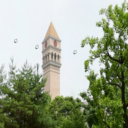

In [15]:
image_query = X_test[check_index].view(1,-1)
label_query = Y_test[check_index].view(1)
X_total= torch.cat([X_train, image_query], dim=0)
Y_total= torch.cat([Y_train, label_query], dim=0)

test_img = Function.to_pil_image(test_image[check_index])
print('테스트할 이미지 : {}'.format(test_label[check_index].item()))
display(test_img)

In [0]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_total.cpu().detach().numpy())

dist = DistanceMetric.get_metric('manhattan')
dist_cal = dist.pairwise(X_tsne)
dist_sort = np.argsort(dist_cal[-1])
dist_high = dist_sort < 5

들어온 이미지 : 1



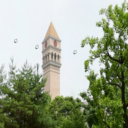



3 번째로 비슷한 이미지 : 


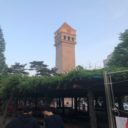



2 번째로 비슷한 이미지 : 


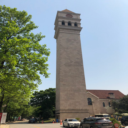



1 번째로 비슷한 이미지 : 


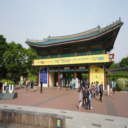



4 번째로 비슷한 이미지 : 


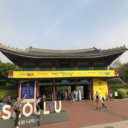



5 번째로 비슷한 이미지 : 


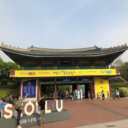

In [17]:
test_img = Function.to_pil_image(test_image[check_index])
print('들어온 이미지 : {}\n'.format(test_label[check_index].item()))
display(test_img)
print("\n")

for ii , rank in enumerate(dist_high):
  if rank > 0 :
    img = Function.to_pil_image(bef_train_image[ii])
    print('{} 번째로 비슷한 이미지 : '.format(dist_sort[ii].item()+1))
    display(img)
    print("\n")
#     img.save('test{}_{}.png'.format(Y_total[ii],ii))
    

## 해당 그래프 그리는 방법은 TFKR 김대하님의 Github를 참고했습니다. 

# [바로가기](https://github.com/kdhht2334/Triplet_loss_for_image_retrieval?fbclid=IwAR2sBMRu6ae7XCMBfotevsttCDQGV5DcUvBLkUOS93izbpXlR7JrRzkJYvc)

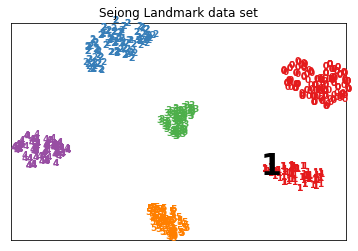

In [30]:
plot_embedding(X_tsne, Y_total,"Sejong Landmark data set")
plt.show()